In [1]:
from Chemometrics.import_common import *
import matplotlib.pyplot as plt
import json

%matplotlib inline
plt.rcParams['font.sans-serif'] = 'SimHei'

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split,\
                                    cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb

In [3]:
Xy = pload('整理后原始数据Xy.p')
X, y = Xy['X'], Xy['y']

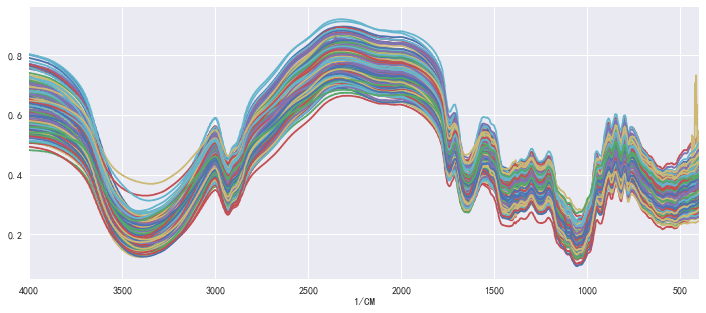

In [4]:
X.iloc[:, -1::-1].T.plot(legend=False, figsize=(12,5))

In [4]:
#data split
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

# basemodel: logistic regression
 lr = pload('LR_model.p')# 不能直接load, 因为是data snooping数据泄露，未来函数

In [6]:
lr = LogisticRegression()
params = dict(C=np.logspace(2, 5, 10))
grid = GridSearchCV(lr, param_grid=params)
with timer('LR模型训练'):
    grid.fit(X_train, y_train)
lr_model = grid.best_estimator_
with timer('最佳LR模型CV evaluate'):
    yhat_cvtest = cross_val_predict(lr_model, X_train, y_train)
with timer('最佳LR模型预测{}个样本'.format(X_test.shape[0])):
    yhat_test = lr_model.predict(X_test)
print(classification_report(y_train, yhat_cvtest))
print(classification_report(y_test, yhat_test))

LR模型训练 done in 32.6s
最佳LR模型CV evaluate done in 3.67s
最佳LR模型预测80个样本 done in 0.0s
             precision    recall  f1-score   support

          0       1.00      0.80      0.89         5
          1       1.00      1.00      1.00         9
          2       1.00      1.00      1.00         9
          3       0.73      0.62      0.67        13
          4       0.91      0.91      0.91        69
          5       1.00      0.95      0.97        41
          6       0.77      0.87      0.82        23
          7       0.90      1.00      0.95        44
          8       1.00      0.89      0.94        27

avg / total       0.92      0.92      0.92       240

             precision    recall  f1-score   support

          0       1.00      0.40      0.57         5
          1       1.00      1.00      1.00         1
          2       1.00      1.00      1.00         1
          3       1.00      1.00      1.00         7
          4       0.88      1.00      0.93        21
          5    

# lightgbm

In [219]:
train_dataset = lgb.Dataset(X_train, label=y_train)
test_dataset = lgb.Dataset(X_test, y_test)
_cv_results = {}

In [215]:
#有哪些参数？
params = {
    'task': 'predict',#?
    'boost': 'gbdt',
    'objective': 'multiclass',
    'num_class': 9
}

important_parameters = {
    #complixity
    'num_leaves': 6,
    'min_data_in_leaf': 10,
    'max_depth': 4,
    'lamda_l1': 1,
    'lamda_l2': 1,
    
    #speed
    'bagging_fraction': 1,
    'feature_fraction': .8,
    
    #accuracy
    'learning_rate': .01
}
params.update(important_parameters)
_params = json.dumps(params)

In [210]:
#early stopping: 调n_estimators（alias num_iterations,num_boost_round）

lgb cv done in 97.11s
0.49344838805087254


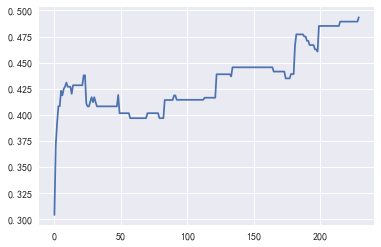

In [220]:
with timer('lgb cv'):
    if _params not in cv_results:
        cv_results_lgb = lgb.cv(params,
                               train_dataset,
                               nfold=5,
                               num_boost_round = 1000,
                               metrics = ['auc'],
                               early_stopping_rounds=100)
        _cv_results[_params] = cv_results_lgb
    else:
        cv_results_lgb = _cv_results[_params]
plt.plot(cv_results_lgb['auc-mean'])
print(np.max(cv_results_lgb['auc-mean']))
opt_niter = np.argmax(cv_results_lgb['auc-mean'])

In [198]:
with timer('train lgb'):
    gbm = lgb.train(params, train_dataset, num_boost_round=opt_niter)

train lgb done in 1.83s


0.9375

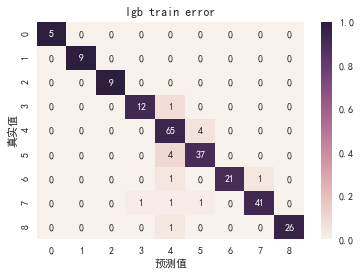

In [202]:
#train error
yfit_train = np.unique(y)[gbm.predict(X_train).argmax(axis=1)]
cm = confusion_matrix(y_train, yfit_train)
plot_ConfusionMatrix(cm)
plt.title('lgb train error')
accuracy_score(y_train, yfit_train)

0.45

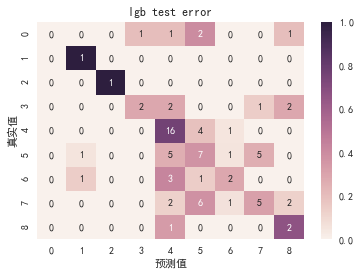

In [191]:
#test error 
yhat_test = np.unique(y)[gbm.predict(X_test).argmax(axis=1)]
cm = confusion_matrix(y_test, yhat_test)
plot_ConfusionMatrix(cm)
plt.title('lgb test error')
accuracy_score(y_test, yhat_test)

---
SVM
1. 核函数： rbf, linear
2. C: 
3. gamma: rbf核的一个参数

In [6]:
from sklearn.svm import SVC

In [7]:
svc = SVC()

SVC training done in 14.99s


({'C': 774.2636826811278, 'kernel': 'linear'}, 0.7916666666666666)

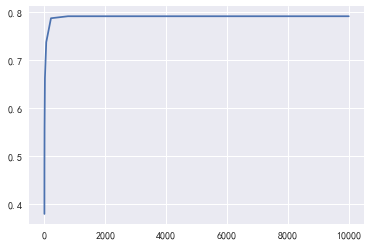

In [100]:
#调参
svc_params = [{'C': np.logspace(-1,4,10), 'kernel': ['linear']},{'C': np.logspace(-1,4,10), 'kernel': ['rbf']}]
grid = GridSearchCV(svc, param_grid=svc_params, n_jobs=-1)
with timer('SVC training'):
    grid.fit(X_train, y_train)
#SVC evaluating
cv_results = pd.DataFrame(dict(grid.cv_results_))
plt.plot(cv_results.param_C, cv_results.mean_test_score)
grid.best_params_, grid.best_score_

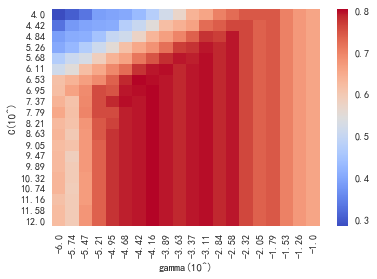

In [67]:
sns.heatmap(cv_results.mean_test_score.values.reshape(len(svc_params['C']), -1),\
            xticklabels=np.round(np.log10(svc_params['gamma']),2),\
            yticklabels=np.round(np.log10(svc_params['C']), 2),\
            cmap=plt.cm.coolwarm)
plt.xlabel('gamma(10^)')
plt.ylabel('C(10^)')

test accuracy score of train set is 79.17%.


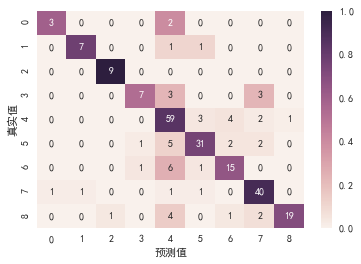

In [101]:
#evaluating
ypred_cv =  cross_val_predict(grid.best_estimator_, X_train, y_train)
cm_train_cvc = confusion_matrix(y_train, ypred_cv)
plot_ConfusionMatrix(cm_train_cvc)
print('test accuracy score of train set is {}%.'.format(round(accuracy_score(y_train, ypred_cv)*100,2)))

test accuracy score of test set is 81.25%


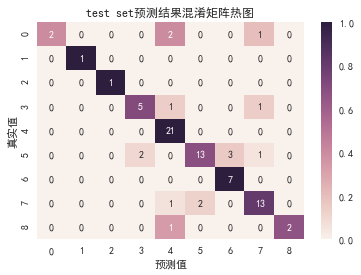

In [102]:
ypred_test = grid.predict(X_test)
cm_test = confusion_matrix(y_test, ypred_test)
plot_ConfusionMatrix(cm_test)
plt.title('test set预测结果混淆矩阵热图')
acc_test = accuracy_score(y_test, ypred_test)
_acc_test = round(acc_test*100, 2)
print('test accuracy score of test set is {}%'.format(_acc_test))

假设1：test set预测效果比train set 交叉验证预测效果好的原因可能是refit
- no. ypred_train_refit = grid.predict(X_train) 这个是train不是test

In [103]:
_X_train, _X_test, _y_train, _y_test = train_test_split(X_train, y_train, test_size=1/3)
best_model = grid.best_estimator_
best_model.fit(_X_train, _y_train)
_ypred_test = best_model.predict(X_test)
__acc_test = accuracy_score(y_test, _ypred_test)
print('test accuracy score of test set is {}%'.format(round(__acc_test*100, 2)))
#预测结果没有refit好， 一定程度上表明refit是有用的，也可以说明样本数目越多模型越准确

test accuracy score of test set is 75.0%


In [104]:
print('classification reprot of SVC model on test set')
print(classification_report(y_test, ypred_test))

classification reprot of SVC model on test set
             precision    recall  f1-score   support

          0       1.00      0.40      0.57         5
          1       1.00      1.00      1.00         1
          2       1.00      1.00      1.00         1
          3       0.71      0.71      0.71         7
          4       0.81      1.00      0.89        21
          5       0.87      0.68      0.76        19
          6       0.70      1.00      0.82         7
          7       0.81      0.81      0.81        16
          8       1.00      0.67      0.80         3

avg / total       0.83      0.81      0.80        80



---
linear svm